In [1]:
from lib import run_definition
from lib import run_result_location
from lib import constants
from lib import run
from os import path
import json
import glob
import numpy as np
import pandas as pd
from jsonpath_ng import jsonpath, parse
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


%matplotlib inline
#global defaults of graphics size
plt.rcParams["figure.figsize"] = [50, 50]

#Define run_id
#run_id = "2020-10-23-15-59-41"
run_id = "2020-11-02-18-36-10"

#point to test result folder containing runs
#location = perfmodel.RunResultLocation("../testresults/azure.1-auto-standalone")
location = run_result_location.RunResultLocation("../testresults/aws.1-auto-standalone")

runDefinition = run_definition.RunDefinition(location)
runDefinition.process_run_samples()
run = runDefinition.find_run(run_id)
meta = run.run_meta
df_latencies = pd.DataFrame(data={'run1': run.export_latency_node_distinct_latencies()})
df_broker_latencies = pd.DataFrame(data={'run1': run.export_broker_node_distinct_latencies()})
df_ping = pd.DataFrame(run.export_ping_series(constants.c_ping_all_metrics))

## Single Detailed Run Analytics

CONFIDENTIAL | NOT FOR DISTRIBUTION | DATA NOT VALIDATED

Cloudprovider: {{meta.cloud_provider}}

Infrastructure: {{meta.infrastructure}}

Run name: {{meta.run_name}}

Run Id: {{meta.run_id}}

Started: {{meta.ts_run_start}}

Ended: {{meta.ts_run_end}}

Duration: {{meta.run_duration_sec()}}


In [2]:
df_lat_series = pd.DataFrame(data=run.export_latency_node_series_latencies(False))
df_lat_series
df_lat_series.groupby('sample_num').latency.mean()
df_lat_series.groupby('sample_num').latency.min()
df_lat_series.groupby('sample_num').latency.max()

sample_num
0     894
1    1780
2     781
3    2281
4     825
5    7521
6     690
7    1257
8     728
9     779
Name: latency, dtype: int32

In [3]:
df_x = df_lat_series.loc[df_lat_series.sample_num == 0, :]
df_x.describe()

,sample_num,latency
count,40000.0,40000.000000
mean,0.0,265.876300
std,0.0,36.716861
min,0.0,172.000000
25%,0.0,244.000000
50%,0.0,253.000000
75%,0.0,277.000000
max,0.0,894.000000


# Key Metrics

### Latency Node Basic Stats

In [4]:
run1_series = df_latencies['run1']
run1_series.describe()

count    400000.000000
mean        262.294490
std          69.525769
min         126.000000
25%         221.000000
50%         239.000000
75%         280.000000
max        7521.000000
Name: run1, dtype: float64

### Broker Node Basic Stats

In [5]:
broker_run1_series = df_broker_latencies['run1']
broker_run1_series.describe()

count    400000.000000
mean        243.062467
std          62.408386
min         102.000000
25%         206.000000
50%         224.000000
75%         258.000000
max        1599.000000
Name: run1, dtype: float64

### Latency Node Quantiles

In [6]:
q1 = run1_series.quantile(q=[0.05,0.1,0.25,0.5,0.75,0.9,0.99,0.995,0.999,0.9999,0.99995,0.99999])
q1

0.05000     202.00000
0.10000     208.00000
0.25000     221.00000
0.50000     239.00000
0.75000     280.00000
0.90000     354.00000
0.99000     508.00000
0.99500     550.00000
0.99900     611.00000
0.99990     719.00010
0.99995     812.00065
0.99999    3528.00999
Name: run1, dtype: float64

### Broker Node Quantiles

In [7]:
broker_q1 = broker_run1_series.quantile(q=[0.05,0.1,0.25,0.5,0.75,0.9,0.99,0.995,0.999,0.9999,0.99995,0.99999])
broker_q1






0.05000    182.0000
0.10000    190.0000
0.25000    206.0000
0.50000    224.0000
0.75000    258.0000
0.90000    322.0000
0.99000    483.0000
0.99500    509.0000
0.99900    572.0000
0.99990    646.0000
0.99995    676.0000
0.99999    804.0014
Name: run1, dtype: float64

<Figure size 1800x1080 with 0 Axes>

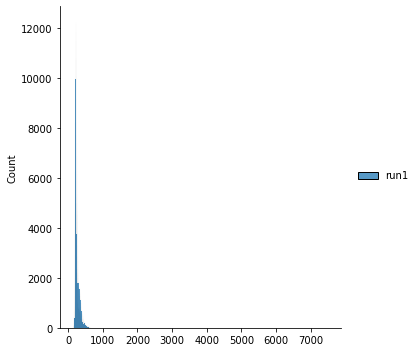

In [8]:
plt.figure(figsize=(25,15))
sns.displot(data=df_latencies)

<Figure size 1800x1080 with 0 Axes>

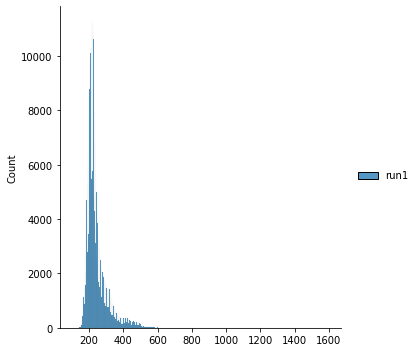

In [9]:
plt.figure(figsize=(25,15))
sns.displot(data=df_broker_latencies)


## DELTA Series

In [10]:
delta_index_latencies = run.export_latency_node_delta_index_latencies(lambda latency: latency >= q1.get(0.99))
df_delta_index_latencies = pd.DataFrame(data={"delta":delta_index_latencies})
df_delta_index_latencies['delta'].describe()

count     4034.000000
mean        93.490084
std        386.705188
min          1.000000
25%         20.000000
50%         40.000000
75%         70.000000
max      13910.000000
Name: delta, dtype: float64

<Figure size 1800x1080 with 0 Axes>

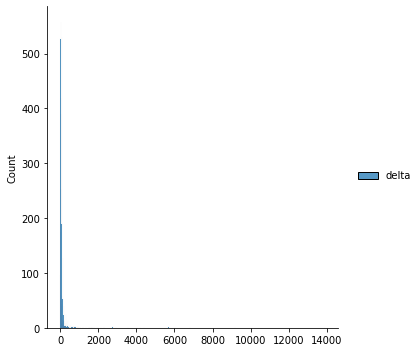

In [11]:
plt.figure(figsize=(25,15))
sns.displot(data=df_delta_index_latencies)

In [12]:
lat_series_length = run.export_latency_node_series_length_latencies(lambda latency: latency >= q1.get(0.99))
s = lat_series_length[constants.k_latency_series_length]
g = lat_series_length[constants.k_latency_gap_length]
df_series_length = pd.DataFrame(data={"series_length": s})
df_series_length = pd.DataFrame(data={"gap_length": g})
df_series_length



,gap_length
0,4287
1,1673
2,420
3,26
4,236
...,...
4020,18
4021,18
4022,48
4023,8
